In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from os import listdir
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from mlxtend.evaluate import scoring

In [2]:
def importar_dados(arquivo):
    df = pd.read_csv(arquivo, sep=' ', names=['x1', 'x2', 'classe'])
    
    X = df[['x1', 'x2']].values
    y = df['classe'].values
    
    return X, y

In [3]:
def exibir_amostras(X, y, 
                    titulo=None, 
                    salvar=False, 
                    figsize=(10, 8), 
                    legend_fontsize=20, 
                    title_fontsize=24, 
                    labels_fontsize=24, 
                    ticks_fontsize=16):
    
    classes = list(set([classe for classe in y]))
    n_classes = len(classes)
    
    plt.figure(figsize=figsize)
    
    for classe in classes:
        plt.scatter(X[y == classe][:, 0], X[y == classe][:, 1], s=100, label='Classe ' + str(classe))
    
    plt.legend(fontsize=legend_fontsize)
    plt.grid(True, linestyle='-', alpha=0.5)
    
    plt.title(str(titulo), fontsize=title_fontsize)
    plt.xlabel(r'$x_{1}$', fontsize=labels_fontsize)
    plt.ylabel(r'$x_{2}$', fontsize=labels_fontsize)
    plt.xticks(fontsize=ticks_fontsize)
    plt.yticks(fontsize=ticks_fontsize)
    
    if salvar:
        plt.savefig(titulo + '.pdf', format='pdf', dpi=300, transparent=True, bbox_inches='tight')
    
#     plt.show()

In [4]:
class AnaliseDiscriminante:
    def __init__ (self, tipo='LDA'):
        self.tipo = tipo
        
    def treinar (self, X, y):
        self.classes = list(set(y))
        self.n_classes = len(self.classes)
        self.n_amostras = len(X)
        self.n_amostras_classe = [len(X[y == c]) for c in self.classes]
        self.probs = [n / self.n_amostras for n in self.n_amostras_classe]
        self.mu = np.mean(X, axis=0)
        self.mu_classe = [np.mean(X[y == c], axis=0) for c in self.classes]
        
        if self.tipo == 'LDA':
            self.sigma = np.cov(X.T)
            self.sigma_inv = np.linalg.inv(self.sigma)
            
        elif self.tipo == 'QDA':
            self.sigma = np.array([np.cov(X[y == c].T) for c in self.classes])
            self.sigma_inv = np.array([np.linalg.inv(matriz) for matriz in self.sigma])
        
        else:
            print("O tipo deve ser 'LDA' ou 'QDA'. Escolha um dos dois!")
    
    def __delta_LDA(self, X, mu, P):
        return (np.matrix(X) * np.matrix(self.sigma_inv).T * np.matrix(mu).T - 0.5 * np.matrix(mu) * np.matrix(self.sigma_inv) * np.matrix(mu).T + np.log(P)).A1[0]
    
    def __delta_QDA(self, X, mu, sigma, sigma_inv, P):
        return (-0.5 * np.log(np.linalg.det(sigma)) - 0.5 * np.matrix(X - mu) * np.matrix(sigma_inv).T * np.matrix(X - mu).T + np.log(P)).A1[0]
        
    def classificar (self, X):
        if self.tipo == 'LDA':
            self.deltas = np.array([[self.__delta_LDA(amostra, self.mu_classe[i], self.probs[i]) for i in range(len(self.classes))] for amostra in X])
        
        elif self.tipo == 'QDA':
            self.deltas = np.array([[self.__delta_QDA(amostra, self.mu_classe[i], self.sigma[i], self.sigma_inv[i], self.probs[i]) for i in range(len(self.classes))] for amostra in X])
        
        else:
            print("O tipo deve ser 'LDA' ou 'QDA'. Escolha um dos dois!")
        
        return np.array([np.argmax(amostra)+1 for amostra in self.deltas])

In [8]:
def holdout(X, y, n_amostras_treino, aleatorio=True, semente=None):
    n_amostras = len(X)
    n_amostras_teste = n_amostras - n_amostras_treino

    if aleatorio:
        if semente == None:
            semente = random.randint(0, 1000)
        random.seed(semente)
        teste_idx = np.array(sorted(random.sample(range(n_amostras), n_amostras_teste)))

    else:
        teste_idx = np.arange(n_amostras - n_amostras_teste - 1, n_amostras)

    treino_idx = np.array(list(set(np.arange(n_amostras)) - set(teste_idx)))
    X_teste = np.array([X[idx] for idx in teste_idx])
    y_teste = np.array([y[idx] for idx in teste_idx])
    X_treino = np.array([X[idx] for idx in treino_idx])
    y_treino = np.array([y[idx] for idx in treino_idx])
    
    return X_treino, y_treino, X_teste, y_teste

In [9]:
def avaliar_desempenho(y_verdadeiro, y_obtido):
    return scoring(y_verdadeiro, y_obtido, metric='accuracy', )

### Dataset 2

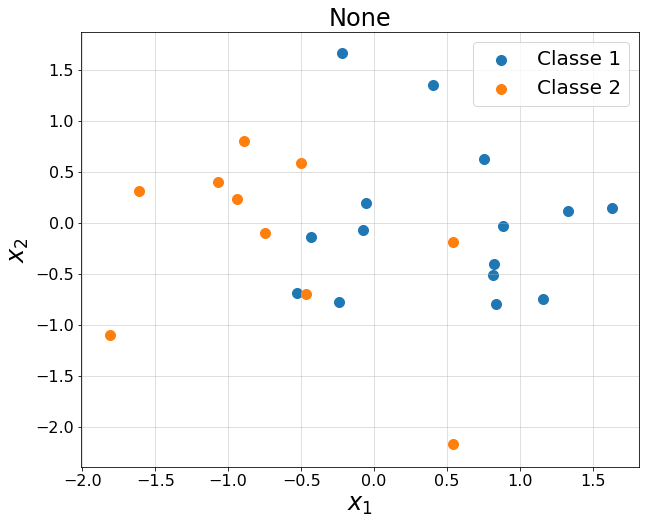

In [10]:
X2, y2 = importar_dados('datasets/dataset2.txt')
exibir_amostras(X=X2, y=y2)

In [11]:
# W1 = W2 = -0.5 * LDA.sigma_inv

# w1 = np.matrix(LDA.sigma_inv) * np.matrix(LDA.mu_classe[0]).T
# w2 = np.matrix(LDA.sigma_inv) * np.matrix(LDA.mu_classe[1]).T

# w10 = -0.5 * np.matrix(LDA.mu_classe[0]) * np.matrix(LDA.sigma_inv) * np.matrix(LDA.mu_classe[0]).T - 0.5 * np.log(np.linalg.det(LDA.sigma)) + np.log(LDA.probs[0])
# w20 = -0.5 * np.matrix(LDA.mu_classe[1]) * np.matrix(LDA.sigma_inv) * np.matrix(LDA.mu_classe[1]).T - 0.5 * np.log(np.linalg.det(LDA.sigma)) + np.log(LDA.probs[1])

# g1 = 

### (a) utilizando 5 amostras para treinar

In [111]:
# Bootstrap
n_repeticoes = 10
n_amostras_treino = 5

LDA_desempenho = []
for execucao in range(n_repeticoes):
    
    # Holdout
    X_treino, y_treino, X_teste, y_teste = holdout(X=X2, y=y2, n_amostras_treino=n_amostras_treino, aleatorio=True, semente=None)
    
    # LDA - Próprio
    LDA = AnaliseDiscriminante(tipo='LDA')
    LDA.treinar(X=X_treino, y=y_treino)
    LDA_y_predito = LDA.classificar(X=X_teste)
    LDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=LDA_y_predito))

LDA_desempenho = np.array(LDA_desempenho)
LDA_desempenho_media = np.mean(LDA_desempenho)

print('DATASET 2')
print('Acurácia: {0:3.4f}'.format(LDA_desempenho_media))

DATASET 2
Acurácia: 0.6100


In [112]:
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z5 = LDA.classificar(np.c_[xx.ravel(), yy.ravel()])

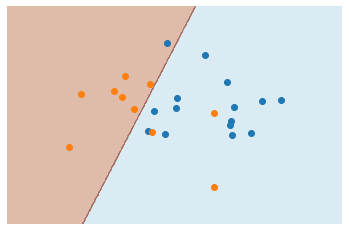

In [113]:
Z5 = Z5.reshape(xx.shape)
plt.contourf(xx, yy, Z5, cmap='Paired', alpha=0.4)
plt.axis('off')

# Plot also the training points
plt.scatter(X2[y2==1][:, 0], X2[y2==1][:, 1], cmap='Paired')
plt.scatter(X2[y2==2][:, 0], X2[y2==2][:, 1], cmap='Paired')

### (b) utilizando 20 amostras para treinar

In [120]:
# Bootstrap
n_repeticoes = 10
n_amostras_treino = 20

LDA_desempenho = []
for execucao in range(n_repeticoes):
    
    # Holdout
    X_treino, y_treino, X_teste, y_teste = holdout(X=X2, y=y2, n_amostras_treino=n_amostras_treino, aleatorio=True, semente=None)
    
    # LDA - Próprio
    LDA = AnaliseDiscriminante(tipo='LDA')
    LDA.treinar(X=X_treino, y=y_treino)
    LDA_y_predito = LDA.classificar(X=X_teste)
    LDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=LDA_y_predito))

LDA_desempenho = np.array(LDA_desempenho)
LDA_desempenho_media = np.mean(LDA_desempenho)

print('DATASET 2')
print('Acurácia: {0:3.4f}'.format(LDA_desempenho_media))

DATASET 2
Acurácia: 0.8000


In [121]:
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z20 = LDA.classificar(np.c_[xx.ravel(), yy.ravel()])

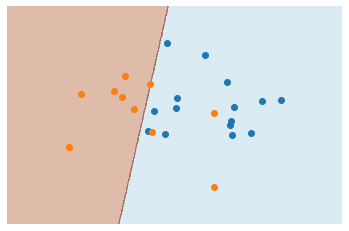

In [122]:
Z20 = Z20.reshape(xx.shape)
plt.contourf(xx, yy, Z20, cmap='Paired', alpha=0.4)
plt.axis('off')

# Plot also the training points
plt.scatter(X2[y2==1][:, 0], X2[y2==1][:, 1], cmap='Paired')
plt.scatter(X2[y2==2][:, 0], X2[y2==2][:, 1], cmap='Paired')

### Sobrepondo ambos os casos

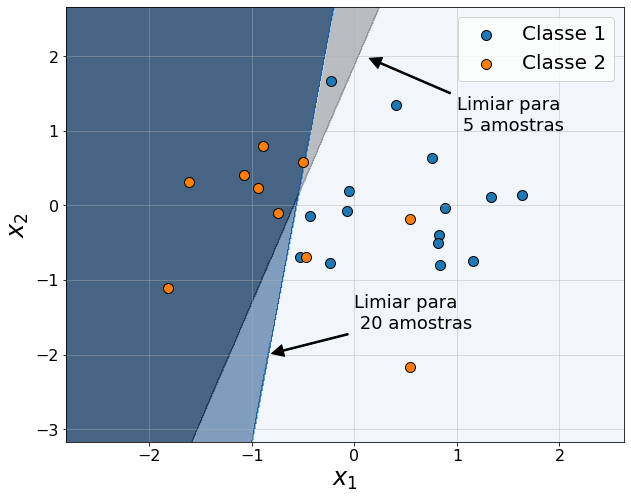

In [200]:
classes = list(set([classe for classe in y2]))
n_classes = len(classes)

plt.figure(figsize=(10, 8))

Z5 = Z5.reshape(xx.shape)
plt.contourf(xx, yy, Z5, cmap='Greys', alpha=0.5)

plt.annotate('Limiar para\n 5 amostras', 
             xy=(0.1, 2), 
             xytext=(1, 1), 
             arrowprops=dict(facecolor='black', 
                             shrink=0.05, 
                             width=1.5, 
                             edgecolor='black'), 
             color='black', 
             fontsize=18)

Z20 = Z20.reshape(xx.shape)
plt.contourf(xx, yy, Z20, cmap='Blues', alpha=0.5)

plt.annotate('Limiar para\n 20 amostras', 
             xy=(-0.85, -2), 
             xytext=(0, -1.65), 
             arrowprops=dict(facecolor='black', 
                             shrink=0.05, 
                             width=1.5, 
                             edgecolor='black'), 
             color='black', 
             fontsize=18)

for classe in classes:
    plt.scatter(X2[y2 == classe][:, 0], X2[y2 == classe][:, 1], edgecolors='black', s=100, label='Classe ' + str(classe))

plt.legend(fontsize=20)
plt.grid(True, linestyle='-', alpha=0.5)

plt.xlabel(r'$x_{1}$', fontsize=24)
plt.ylabel(r'$x_{2}$', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('prova_8_limiar.pdf', format='pdf', dpi=300, transparent=True, bbox_inches='tight')

plt.show()